### OPTICS

&nbsp;

OPTICS is a variation of DBSCAN. One of the biggest malaise for DBSCAN is to find the appropriate ε. OPTICS uses a special ordering based upon the organic order and the reachability distance to skip the needle search of optimal ε in the haystack. Although the quadratic time complexity of the algorithm can be avoided with the input of ε. As a result of quid pro quoi, ξ is a new parameter to determine the steep upward and downward areas in reachability plot. The valleys between steep upward and downward areas would be identified as clusters.

For technical details of DBSCAN, you can click the link below.

https://github.com/je-suis-tm/machine-learning/blob/master/dbscan.ipynb

For technical details of OPTICS, you can read the original paper.

https://www.dbs.ifi.lmu.de/Publikationen/Papers/OPTICS.pdf

&nbsp;

In [1]:
import sklearn.cluster
import sklearn.decomposition
import sklearn.datasets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy

In [2]:
#compute euclidean distance matrix from dataframe
#using numpy ndarray is faster
#you can use scipy spatial matrix as well
# import scipy.spatial
# scipy.spatial.distance_matrix(data,data)
def get_distance_matrix(data):

    #initialize
    dist_mat=np.zeros((len(data),len(data)))

    #computing only upper triangle matrix to boost efficiency
    for i in range(len(data)):
        for j in range(i+1,len(data)):
            euclidean_dist=sum((data.loc[j]-data.loc[i])**2)**0.5
            dist_mat[i][j]=euclidean_dist
            dist_mat[j][i]=euclidean_dist
        
    return dist_mat

In [3]:
#prepare core distance and reachability distance for ordering
#based upon definition 5 and 6 in the original paper
def get_core_and_reach(dist_mat,minpts):

    #computing core distance
    #basically the minimum epsilon to make a random point core
    #a core point must have at least minpts points within the radius of epsilon
    #thus core distance would be the minpts-th data inside the distance matrix
    #using index minpts cuz index 0 should be zero
    #the euclidean distance of itself
    core_dist=[sorted(dist_mat[i])[minpts] for i in range(len(dist_mat))]

    #reachability distance from one point to another
    #is the a larger number between core distance and euclidean distance
    #as one of the points have to be a core point
    #even a smaller euclidean distance has to satisfy the condition of core
    reach_dist=np.zeros((len(dist_mat),len(dist_mat)))

    for i in range(len(dist_mat)):
        
        #set diagonal inf
        #as there is no point to check the distance from data point to itself
        reach_dist[i][i]=float('inf')
        for j in range(len(dist_mat)):
            reachability=max(core_dist[j],dist_mat[i][j])
            reach_dist[i][j]=reachability
            
    return core_dist,reach_dist

In [4]:
#the idea of ordering by reachability distance
#can be thought of as mapping high dimensional data into one dimension
#data points with small reachability distance become neighbors on one axis
#then we determine the area of clusters on one axis based upon ξ and minpts
#based upon figure 6 and 7 in the original paper
def get_ordering(reach_dist):

    #i know using dataframe is slow
    #but it is quite convenient, lol
    #as this is reinventing the wheel
    #the performance does not really matter
    reach_df=pd.DataFrame(reach_dist)

    #while iterating through the reachability distance matrix
    #pick the data point with the smallest reachability distance to the current point
    ordering=[]
    for i in range(len(reach_df)):
        ordering.append(reach_df.loc[i].idxmin())
        del reach_df[ordering[-1]]
        
    return ordering

In [5]:
#get upward and downward areas based upon definition 10 in the original paper
def get_up_down_areas(reach_plot,reach_plot_df,minpts):

    start=None;end=None
    steep_areas=[]

    #detect steep areas regardless of upward/downward
    for i in range(len(reach_plot)):

        if start:

            #inside the steep areas
            #reachability distance change should be the same direction
            sign_condition=reach_plot_df.at[i,'xi']*reach_plot_df.at[start,'xi']>=0

            #inside the steep areas
            #there should not be more than minpts non-ξ data points
            #otherwise they can form a cluster
            core_condition=len(reach_plot_df[reach_plot_df['xi']==0].loc[start:i])<minpts

            #both start and end should be ξ data points
            xi_condition=reach_plot_df.at[i,'xi']==reach_plot_df.at[start,'xi']

            #only increment when both conditions are met
            if sign_condition and core_condition:

                #new end identified
                if xi_condition:
                    end=i  

            #one steep area is identified
            else:

                #only add steep area when we have more than one ξ data point
                if start and end:
                    steep_areas.append([start,end])
                start=None;end=None

        #should not use else condition
        #when if current data point has opposite ξ to start
        #current data point should become the new start
        if not start:        
            if reach_plot_df.at[i,'xi']!=0:
                start=i

    #end of dataframe append
    if start and end:
        steep_areas.append([start,end])

    #differentiate upward and downward areas
    up_areas=[]
    down_areas=[]
    for i in steep_areas:
        if reach_plot_df.at[i[0],'xi']==1:
            up_areas.append(i)
        else:
            down_areas.append(i)

    return up_areas,down_areas

In [6]:
#get clusters based upon definition 11 in the original paper
def find_clusters(up_areas,down_areas,reach_plot,xi,minpts):

    clusters=[]
    for i in down_areas:

        start_down=i[0]
        end_down=i[-1]
        
        #up areas start must be larger than down areas end
        valid_up_areas=[ii for ii in up_areas if ii[0]>end_down]

        for j in valid_up_areas:

            start_up=j[0]
            end_up=j[-1]
            
            #condition 3b
            mib=max(reach_plot[start_down+1:end_up])
            sc_1_star=mib<=reach_plot[start_down]*(1-xi)
            sc_2_star=mib<=reach_plot[end_up]*(1-xi)        

            if sc_1_star and sc_2_star:
                
                #condition 4
                fig_18_b=reach_plot[start_down]*(1-xi)>=reach_plot[end_up]
                fig_18_a=reach_plot[end_up]*(1-xi)>=reach_plot[start_down]

                if fig_18_b:
                    cluster_start=max([ii for ii in reach_plot[start_down:end_down+1] if ii>reach_plot[end_up+1]])
                    cluster_end=end_up
                elif fig_18_a:
                    cluster_start=start_down
                    cluster_end=min([ii for ii in reach_plot[start_up:end_up+1] if ii<reach_plot[start_down]])
                else:
                    cluster_start=start_down
                    cluster_end=end_up

                #condition 3a
                if cluster_end-cluster_start>minpts-1:
                    clusters.append([cluster_start,cluster_end])
                    
    return clusters

In [7]:
#create dataframe
xcol=['x0','x1','x2','x3']
ycol='y'
iris=sklearn.datasets.load_iris()
df=pd.DataFrame(iris.data,columns=xcol)

In [8]:
#each input factor has to be float/int
#sklearn has already done that for us
#but if you are using the dataset inside the repository
#you can use np.unique to convert categorical data to int
df[ycol]=iris.target

In [9]:
#minpts denotes the minimum requirement to form a cluster
#minpts should be larger than 2
#there are different empirical rules
#it can be 2 times dimensions
#or it can be dimensions+1
minpts=1+len(xcol)

#ξ determines the steep upward and downward areas in reachability plot
#the valleys between steep upward and downward areas
#would be identified as clusters
xi=0.05

In [10]:
dist_mat=get_distance_matrix(df)

In [11]:
core_dist,reach_dist=get_core_and_reach(dist_mat,minpts)

ordering=get_ordering(reach_dist)

In [12]:
reach_plot=[reach_dist[ind][val] for ind,val in enumerate(ordering)]

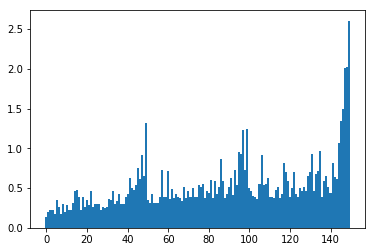

In [13]:
plt.bar(range(0,len(ordering)),
        reach_plot,
        width=1)
plt.show()

In [14]:
reach_plot_df=pd.DataFrame()
reach_plot_df['data']=reach_plot

reach_plot_df['pct']=reach_plot_df['data'].pct_change()

reach_plot_df['xi']=np.select([reach_plot_df['pct']>=xi,reach_plot_df['pct']<=-xi],[1,-1])

In [15]:
up_areas,down_areas=get_up_down_areas(reach_plot,reach_plot_df,minpts)

In [16]:
clusters=find_clusters(up_areas,down_areas,reach_plot,xi,minpts)